# Batina Advanced Weight Recovery

This notebook demonstrates how to guess a floating number using Hamming Weight model.

We generate a random secret floating number. Then we use hamming weight model to guess the number.


In [1]:
import pathlib
TEST_RESULT_DIR = './results'

pathlib.Path(TEST_RESULT_DIR).mkdir(parents=True, exist_ok=True) 

In [2]:
import sys
sys.path.append("../")

from pybatina.advanced_weight_recovery import *
from pybatina.utils import *

In [3]:
import numpy as np

guess_range=(-5.0, 5.0)
# the number of guess values in the guess range
secret_number = np.random.uniform(guess_range[0], guess_range[1]) 
secret_number = 2.538146734
secret_number = int_to_float(float_to_int(secret_number))
print('secret_number =', secret_number)

secret_number = 2.538146734237671


In [4]:
number_of_best_candidates = 30
awr = AdvancedWeightRecovery(guess_range=guess_range, number_of_best_candidates=number_of_best_candidates)

## ONE STEP

In [5]:
%%time
secret_hamming_weight_set = [np.vectorize(hamming_weight)(input_values * secret_number) for input_values in awr.input_value_set]    
s = awr.recover_weight(secret_hamming_weight_set)
s.iloc[:awr.number_of_best_candidates]

<timed exec>:1: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
../pybatina/advanced_weight_recovery.py:200: RuntimeWarning: invalid value encountered in greater_equal
  guess_numbers = guess_numbers[np.where(np.logical_and(guess_numbers >= self.guess_range[0], guess_numbers <= self.guess_range[1]))]
../pybatina/advanced_weight_recovery.py:200: RuntimeWarning: invalid value encountered in less_equal
  guess_numbers = guess_numbers[np.where(np.logical_and(guess_numbers >= self.guess_range[0], guess_numbers <= self.guess_range[1]))]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


CPU times: user 15.5 s, sys: 299 ms, total: 15.8 s
Wall time: 15.9 s


2.538147    1.000000
2.538146    0.837526
2.538147    0.827563
2.538146    0.793734
2.538147    0.785723
2.538146    0.776813
2.538147    0.766772
2.538148    0.749668
2.539659    0.630515
2.538160    0.625454
2.539658    0.622354
2.538155    0.614548
2.538155    0.610582
2.538155    0.609646
2.538163    0.582583
2.538162    0.582433
2.538164    0.576704
2.538163    0.576332
2.539659    0.554911
2.539658    0.544583
2.536018    0.437615
2.540787    0.416476
2.536783    0.401659
2.536783    0.382177
2.536783    0.381623
2.536783    0.381408
2.539666    0.370854
2.539666    0.367989
3.988579    0.353594
3.988579    0.309995
dtype: float64

## STEP-BY-STEP

### Correlation of mantissa

In [6]:
%%time

numbers = None
mantissa_correlations = {}
known_inputs = awr.build_input_values(component='mantissa')
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number).astype(np.float32)
for mantissa_byte_index in range(len(AdvancedWeightRecovery.MANTISSA_THREE_BYTES)):
    if numbers is not None:
        mantissa_corr = pd.Series()
        for number in numbers:
            guess_numbers = awr.build_guess_values(component='mantissa', mantissa_byte_index=mantissa_byte_index, numbers=np.asarray([number]))
            corr = awr.compute_corr_numbers(secret_hw, known_inputs, guess_numbers).sort_values(ascending=False)
            mantissa_corr = pd.concat([mantissa_corr, corr.iloc[:4]])
    else:
        guess_numbers = awr.build_guess_values(component='mantissa', mantissa_byte_index=mantissa_byte_index, numbers=None)
        mantissa_corr = awr.compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

    mantissa_corr.sort_values(ascending=False, inplace=True)
    numbers = mantissa_corr.index[:awr.number_of_best_candidates]
    mantissa_correlations[mantissa_byte_index] = mantissa_corr

<timed exec>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


CPU times: user 13.4 s, sys: 175 ms, total: 13.6 s
Wall time: 13.6 s


01000000001000100111000011111111 2.538146734237671 ----------
00111111101000100110000000000000 1.2685546875 0.24234961947080474
01000000001000100111000011111111 2.538146734237671 ----------
00111111101000100111000100000000 1.269073486328125 0.5306286955362121
01000000001000100111000011111111 2.538146734237671 ----------
00111111101000100111000011111111 1.2690733671188354 0.6192014991843868


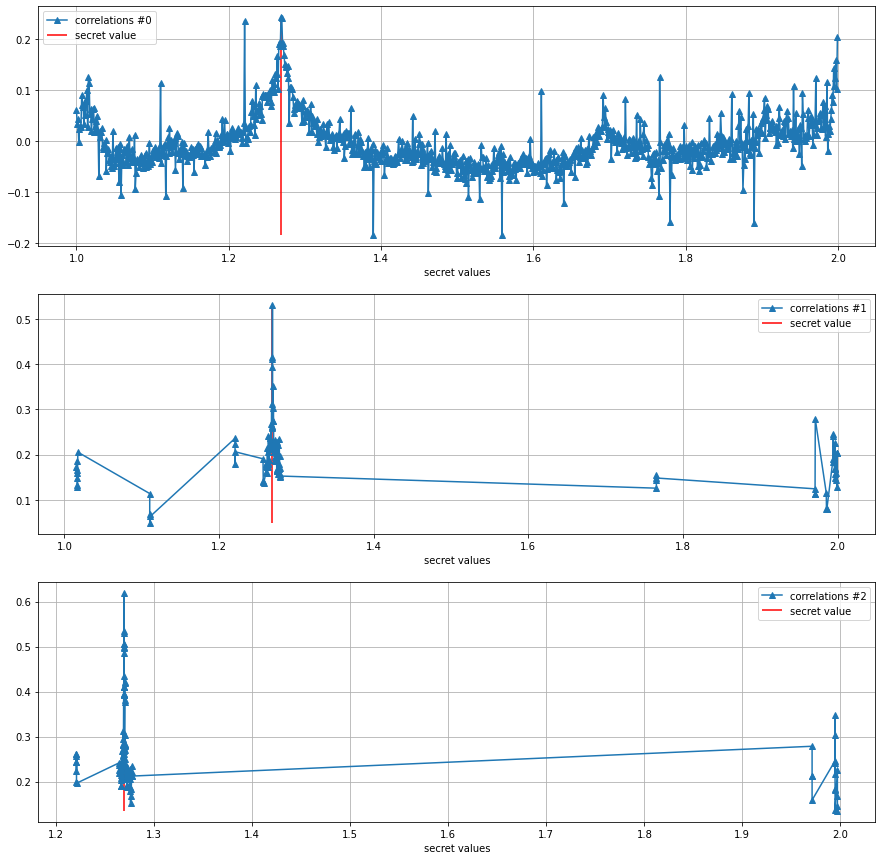

In [7]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=len(mantissa_correlations), ncols=1, figsize=(15, 5 * len(mantissa_correlations)))
for idx in range(len(mantissa_correlations)):
    corr = mantissa_correlations[idx].sort_index()
    corr.plot(ax=ax[idx], label='correlations #%d' % idx, kind='line', marker='^')
    x = int_to_float((float_to_int(abs(secret_number)) & ~(0xff<<AdvancedWeightRecovery.MAX_MANTISSA_NBITS)) | (127<<AdvancedWeightRecovery.MAX_MANTISSA_NBITS))
    ax[idx].vlines(x, corr.min(), corr.max(), color='red', label='secret value')
    ax[idx].legend()
    ax[idx].grid(True)
    ax[idx].set_xlabel('secret values')
    
    x = abs(secret_number)
    print('{:032b}'.format(float_to_int(x)), x, '-' * 10)
    x = mantissa_correlations[idx].index[0]
    print('{:032b}'.format(float_to_int(x)), x, mantissa_correlations[idx].iloc[0])

In [8]:
mantissa_correlations[2].iloc[:20]

1.269073    0.619201
1.269073    0.533838
1.269073    0.530629
1.269074    0.505827
1.269073    0.505561
1.269073    0.499266
1.269074    0.496506
1.269074    0.485551
1.269080    0.433723
1.269829    0.422123
1.269829    0.419382
1.269078    0.410332
1.269077    0.410287
1.269077    0.410024
1.269081    0.394422
1.269081    0.393866
1.269082    0.392731
1.269082    0.392353
1.269829    0.380976
1.269829    0.375940
dtype: float64

In [9]:
numbers=np.asarray(mantissa_corr.index[:awr.number_of_best_candidates])
numbers

array([1.26907337, 1.26907325, 1.26907349, 1.26907361, 1.26907313,
       1.26907301, 1.26907372, 1.26907384, 1.26908016, 1.26982927,
       1.26982915, 1.26907754, 1.2690773 , 1.26907742, 1.26908135,
       1.26908112, 1.26908207, 1.26908159, 1.26982939, 1.26982903,
       1.99428952, 1.26800919, 1.99428964, 1.27039337, 1.26839137,
       1.26839125, 1.26983309, 1.26983285, 1.26839149, 1.26839161])

# sign

In [10]:
positive_corr = awr.compute_corr_numbers(secret_hw=secret_hw, known_inputs=known_inputs, guess_numbers=numbers)
negative_corr = awr.compute_corr_numbers(secret_hw=secret_hw, known_inputs=known_inputs, guess_numbers=-numbers)

In [11]:
corr = positive_corr
if positive_corr.sum() < negative_corr.sum():
    numbers = -numbers
    corr = negative_corr
numbers

array([1.26907337, 1.26907325, 1.26907349, 1.26907361, 1.26907313,
       1.26907301, 1.26907372, 1.26907384, 1.26908016, 1.26982927,
       1.26982915, 1.26907754, 1.2690773 , 1.26907742, 1.26908135,
       1.26908112, 1.26908207, 1.26908159, 1.26982939, 1.26982903,
       1.99428952, 1.26800919, 1.99428964, 1.27039337, 1.26839137,
       1.26839125, 1.26983309, 1.26983285, 1.26839149, 1.26839161])

Text(0.5, 0, 'secret values')

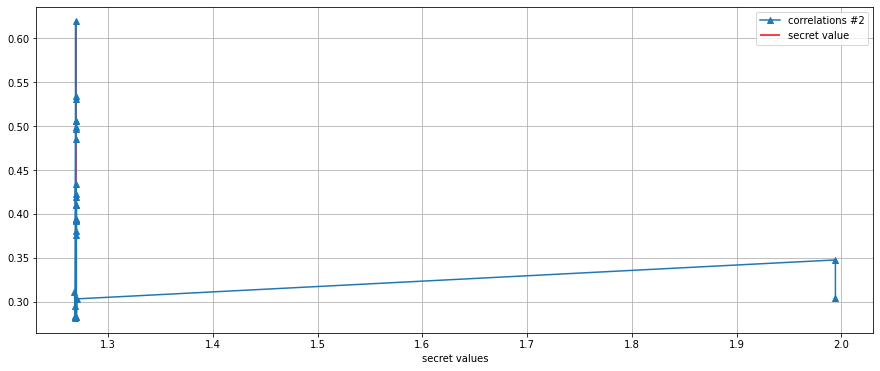

In [12]:
from matplotlib import pyplot as plt
ax = corr.sort_index().plot(label='correlations #%d' % idx, figsize=(15,6), marker='^')
x = int_to_float((float_to_int(secret_number) & ~(0xff<<AdvancedWeightRecovery.MAX_MANTISSA_NBITS)) | (127<<AdvancedWeightRecovery.MAX_MANTISSA_NBITS))
ax.vlines(x, corr.min(), corr.max(), color='red', label='secret value')
ax.legend()
ax.grid(True)
ax.set_xlabel('secret values')

### Correlation exponent

In [13]:
%%time
known_inputs = awr.build_input_values(component='exponent')
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
guess_numbers = awr.build_guess_values(component='exponent', numbers=numbers)
guess_numbers = guess_numbers[np.where(np.logical_and(guess_numbers >= guess_range[0], guess_numbers <= guess_range[1]))]
mantisa_exp_corr = awr.compute_corr_numbers(secret_hw, known_inputs, guess_numbers).sort_values(ascending=False)

<timed exec>:2: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
<timed exec>:4: RuntimeWarning: invalid value encountered in greater_equal
<timed exec>:4: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


CPU times: user 1.63 s, sys: 36 ms, total: 1.66 s
Wall time: 1.66 s


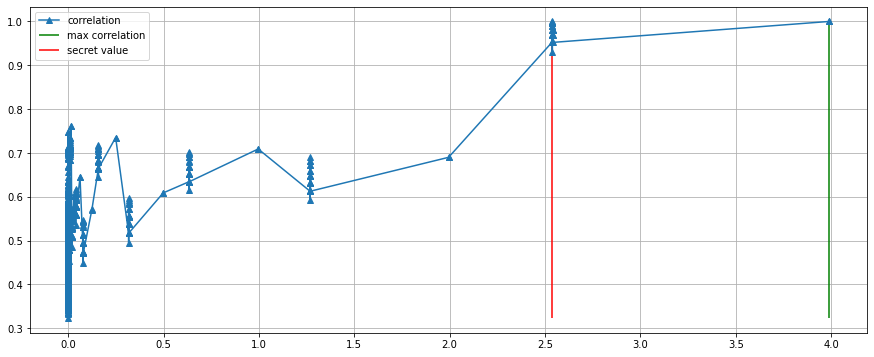

In [14]:
ax = mantisa_exp_corr.sort_index().plot(figsize=(15,6), label='correlation', marker='^')
ax.vlines(mantisa_exp_corr.idxmax(), mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='green', label='max correlation')
ax.vlines(secret_number, mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='red', label='secret value')
ax.legend()
ax.grid()

In [16]:
x = secret_number
print('{:032b}'.format(float_to_int(x)), x)

idx = 1
x = mantisa_exp_corr.index[idx]
print('{:032b}'.format(float_to_int(x)), x, mantisa_exp_corr.iloc[idx])

01000000001000100111000011111111 2.538146734237671
01000000001000100111000011111111 2.538146734237671 0.9999999999999999


### Last sorting

In [24]:
known_inputs = awr.build_input_values(component='mantissa')
#known_inputs = np.random.uniform(-10, 10, 1000)
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number).astype(np.float32)
full_corr = AdvancedWeightRecovery.compute_corr_numbers(secret_hw, known_inputs, np.asarray(mantisa_exp_corr.index[:number_of_best_candidates])).sort_values(ascending=False)

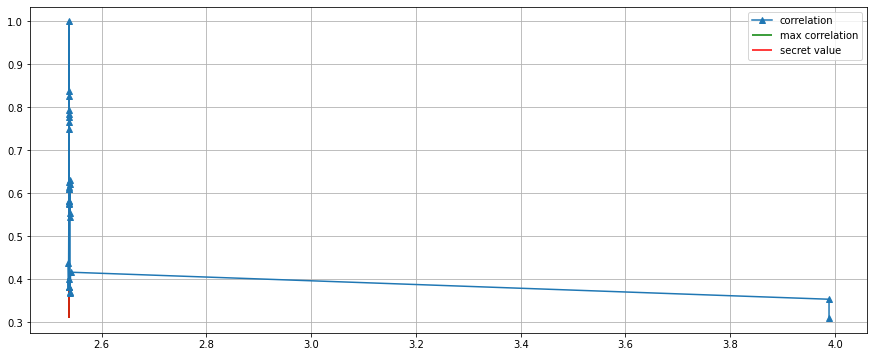

In [25]:
ax = full_corr.sort_index().plot(figsize=(15,6), label='correlation', marker='^')
ax.vlines(full_corr.idxmax(), full_corr.min(), full_corr.max(), color='green', label='max correlation')
ax.vlines(secret_number, full_corr.min(), full_corr.max(), color='red', label='secret value')
ax.legend()
ax.grid()

In [28]:
full_corr.iloc[:5]

2.538147    1.000000
2.538146    0.837526
2.538147    0.827563
2.538146    0.793734
2.538147    0.785723
dtype: float64

### Result

In [37]:
print('secret_number:', secret_number)
print('the best guessed value:', full_corr.index[0], 'Correlation:', full_corr.iloc[0])

secret_number: 2.538146734237671
the best guessed value: 2.538146734237671 Correlation: 1.0
